In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import Prophet, ARIMA, RNNModel, RandomForest, TransformerModel, CatBoostModel
import darts.metrics as metrics
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## 1. Load data as a darts TimeSeries

In [3]:
df = pd.read_pickle("data.pkl")
df.index = pd.to_datetime(df.index, format='%Y')

label_encoder = LabelEncoder()
df['cocnumber'] = label_encoder.fit_transform(df['cocnumber'])

selected_covariates = ['hou_mkt_rentvacancy_xt', 'hou_mkt_ovrcrowd_xt',
    'hou_mkt_pctoverhouse_psh_hud', 'hou_mkt_evict_rate',
    'hou_pol_eli_psh_hud','d_hou_pol_hudunit_psh_hud_share',
    'd_hou_pol_occhudunit_psh_hud', 'hou_pol_fedfundcoc',  
    'econ_labor_unemp_rate_BLS', 'econ_labor_incineq_xt', 
    'econ_sn_cashasst_xt', 'sub_high_cost_homeval75',
    'sub_high_rent_share75', 'tight_high_cost_rental_mkt',
    'sub_tight_high_cost_rent','suburban',
    'Mortality_Rank', 'Morbidity_Rank', 'Health_Behaviors_Rank',
    'Clinical_Care_Rank','Social_&_Economic_Factors_Rank', 
    'Physical_Environment_Rank', 'd_hou_mkt_burden_sev_rent_xt', 
    'dem_soc_ed_lesshs_xt','dem_pop_female_census_share',
    'dem_pop_mig_census_share', 'dem_soc_singparent_xt', 'dem_soc_vet_xt']

final_cols = ['cocnumber', 'pit_tot_hless_pit_hud']
final_cols.extend(selected_covariates)

df = df[final_cols]
df


,cocnumber,pit_tot_hless_pit_hud,hou_mkt_rentvacancy_xt,hou_mkt_ovrcrowd_xt,hou_mkt_pctoverhouse_psh_hud,hou_mkt_evict_rate,hou_pol_eli_psh_hud,d_hou_pol_hudunit_psh_hud_share,d_hou_pol_occhudunit_psh_hud,hou_pol_fedfundcoc,...,Health_Behaviors_Rank,Clinical_Care_Rank,Social_&_Economic_Factors_Rank,Physical_Environment_Rank,d_hou_mkt_burden_sev_rent_xt,dem_soc_ed_lesshs_xt,dem_pop_female_census_share,dem_pop_mig_census_share,dem_soc_singparent_xt,dem_soc_vet_xt
year,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,212.0,6.315952,1.891332,10.000000,3.050000,74.000000,-0.249382,-1.010808,8.84256,...,29.000000,27.000000,5.000000,70.000000,-1.262639,8.814938,49.970783,-0.052773,24.139337,10.172604
2011-01-01,0,182.0,7.026713,1.541145,10.000000,3.110000,74.000000,-0.319067,-5.000000,8.84256,...,16.000000,50.000000,7.000000,11.000000,-3.322617,6.816218,50.157089,0.017149,14.119467,9.161098
2012-01-01,0,196.0,4.374162,1.672888,10.000000,2.910000,76.000000,-0.319067,-5.000000,9.10018,...,4.000000,29.000000,7.000000,60.000000,-3.322617,6.494505,50.214504,-0.705931,13.415127,7.541328
2013-01-01,0,185.0,7.026713,1.541145,10.000000,2.830000,76.000000,-0.319067,-5.000000,9.00825,...,5.000000,17.000000,7.000000,25.000000,-3.322617,6.816218,50.183338,-0.541909,14.119467,9.161098
2014-01-01,0,166.0,4.374162,1.672888,9.000000,2.370000,70.000000,-0.319067,-5.000000,8.83565,...,6.000000,23.000000,6.000000,97.000000,-3.322617,6.494505,50.209843,-0.572809,13.415127,7.541328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,18,338.0,7.033576,1.366765,12.223763,1.371572,68.023903,-0.076877,1.534615,9.61667,...,61.037037,66.259259,64.962963,72.925926,0.923620,10.292239,49.385883,-0.649424,24.510468,13.146316
2014-01-01,18,325.0,7.033576,1.366765,12.616926,1.285725,66.085754,-0.076877,1.534615,10.37964,...,63.074074,66.814815,63.222222,67.703704,0.923620,10.292239,49.312393,-0.127225,24.510468,13.146316
2015-01-01,18,346.0,8.151093,1.398304,12.033099,0.906099,66.798363,-0.076877,1.534615,10.35769,...,66.370370,69.518519,66.000000,67.814815,0.923620,9.383834,49.292053,-0.476394,24.528881,11.009784


In [4]:
cols = list(df.columns)
cols.remove('cocnumber')
series_group = TimeSeries.from_group_dataframe(df, group_cols="cocnumber", value_cols=cols)

## 2. Create time-series models for each CoC

### Facebook Prophet

16:22:36 - cmdstanpy - INFO - Chain [1] start processing


16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:38 - cmdstanpy - INFO - Chain [1] done processing
16:22:38 - cmdstanpy - INFO - Chain [1] 

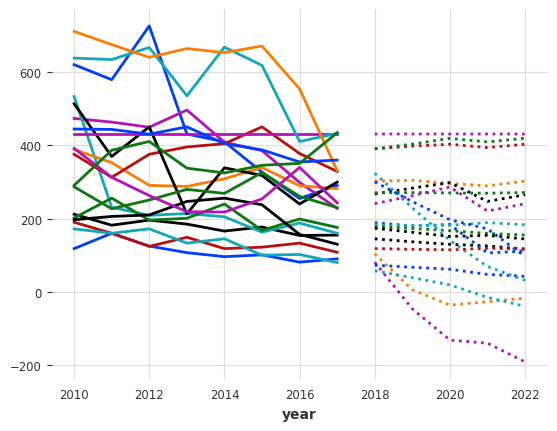

In [6]:
train_length = 5

models = []
forecasts = []

count = 0
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ts in series_group:
    target = ts['pit_tot_hless_pit_hud']
    covariates = ts[selected_covariates]
    
    model = Prophet(growth='logistic', cap=700)
    # model.fit(series=target[:train_length], future_covariates=covariates[:train_length])
    # model.fit(series=target[:train_length])
    model.fit(series=target)

    models.append(model)

    # forecast = model.predict(n=3, future_covariates=covariates[train_length:])
    # forecast = model.predict(n=len(target) - train_length)
    forecast = model.predict(n=5)
    forecasts.append(forecast)

    color = color_cycle[count % len(color_cycle)]
    target.plot(label='actual', color=color)
    forecast.plot(label='predicted', ls=':', color=color)

    count += 1

plt.legend('')
plt.show()

### Random Forest

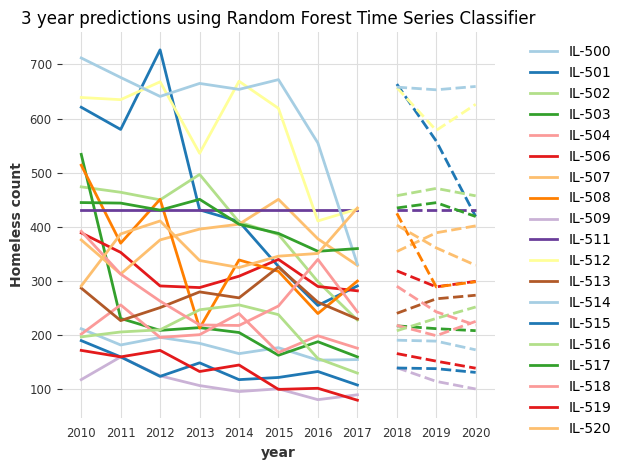

In [28]:
models = []
forecasts = []

count = 0
palette = sns.color_palette("Paired", 20)  # Generate 15 distinct colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ts in series_group:
    target = ts['pit_tot_hless_pit_hud']
    covariates = ts[selected_covariates]
    
    model = RandomForest(lags_past_covariates=1, n_estimators=100, output_chunk_length=6)
    model.fit(series=target, past_covariates=covariates)

    models.append(model)

    forecast = model.predict(n=3)
    forecasts.append(forecast)

    color = color_cycle[count % len(color_cycle)]
    target.plot(label=label_encoder.inverse_transform([count])[0], color=color)
    forecast.plot(label='_', ls='--', color=color)

    count += 1

plt.title("3 year predictions using Random Forest Time Series Classifier")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("Homeless count")
plt.tight_layout()
plt.show()

### Transformer

In [4]:
train_length = 5

models = []
forecasts = []

count = 0
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ts in series_group:
    target = ts['pit_tot_hless_pit_hud']
    covariates = ts[selected_covariates]
    
    model = TransformerModel(input_chunk_length=1, output_chunk_length=6)
    model.fit(series=target, past_covariates=covariates)

    models.append(model)


    forecast = model.predict(n=3)
    forecasts.append(forecast)

    color = color_cycle[count % len(color_cycle)]
    target.plot(label='actual', color=color)
    forecast.plot(label='predicted', ls=':', color=color)

    count += 1

plt.legend('')
plt.show()

/Users/atharvanaik/Desktop/Sem8/CS 498 CSS/cs498-css/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.9 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Tr

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

: 

: 